# Reproducing One-Zone Model Results from Palicio et al. (2023)

In [1]:
import vice
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math as m
from pathlib import Path

In [2]:
onezone_dir = Path('../src/data/onezone/Palicio2023/')

## Model Parameters

### Simulation Time

In [3]:
dt = 0.01
tmax = 13.2
simtime = np.arange(0, tmax+dt, dt) # Gyr

### Yields

Same yields as Johnson et al. (2020) for consistency.

In [4]:
from vice.yields.presets import JW20
vice.yields.sneia.settings['fe'] *= 10**0.1

### DTDs

In [5]:
sys.path.append(os.path.abspath('../migration'))
from src.simulations import dtds

In [6]:
MR01 = dict(
    name = 'MR01',
    RIa = dtds.greggio05_single(tmin=0.03, tmax=tmax, q_slope=0.5, m1_max=10.),
    delay = 0.03,
    color = 'blue',
)
S05 = dict(
    name = 'S05',
    RIa = dtds.utils.gaussian(center=3.4, stdev=0.68),
    delay = 0.25,
    color = 'orange',
)
G05_WIDE = dict(
    name = 'G05_WIDE',
    RIa = dtds.greggio05_double(scheme='wide', tmin=0.04, tmax=tmax, t_nuc_max=0.4, beta_sep=0., dt=1e-4),
    delay = 0.04,
    color = 'purple',
)
G05_CLOSE = dict(
    name = 'G05_CLOSE',
    RIa = dtds.greggio05_double(scheme='close', tmin=0.04, tmax=tmax, t_nuc_max=0.4, beta_grav=-0.975, dt=1e-4),
    delay = 0.04,
    color = 'pink',
)
MPV06 = dict(
    name = 'MPV06',
    RIa = dtds.prompt(peak=0.05, stdev=0.01, timescale=3, tmin=0.03, tmax=10.05),
    delay = 0.03,
    color = 'green',
)
T08 = dict(
    name = 'T08',
    RIa = dtds.powerlaw(slope=-1, tmin=0.1, tmax=10),
    delay = 0.1,
    color = 'cyan',
)
P08 = dict(
    name = 'P08',
    RIa = dtds.powerlaw(slope=-0.5, tmin=0.03, tmax=tmax),
    delay = 0.03,
    color = 'brown',
)

dtd_list = [MR01, S05, G05_WIDE, G05_CLOSE, MPV06, T08, P08]

Computing Greggio 2005 DD WIDE DTD...


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.94it/s]


Computing Greggio 2005 DD CLOSE DTD...


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.49it/s]


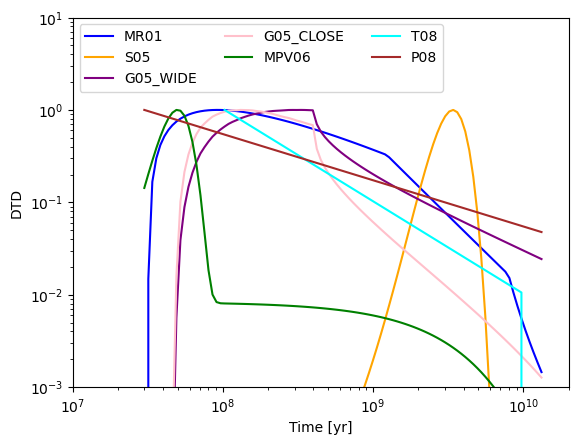

In [7]:
tarr = np.logspace(np.log10(0.03), np.log10(tmax), 100)

fig, ax = plt.subplots()
for dtd in dtd_list:
    func = dtd['RIa']
    x = tarr[tarr >= dtd['delay']]
    y = np.array([func(t) for t in x])
    y /= y.max()
    ax.plot(x * 1e9, y, label=dtd['name'], color=dtd['color'])
ax.set_xscale('log')
ax.set_xlabel('Time [yr]')
ax.set_xlim((1e7, 2e10))
ax.set_ylabel('DTD')
ax.set_yscale('log')
ax.set_ylim((1e-3, 10))
ax.legend(loc='upper left', ncol=3)
plt.show()

## One Infall

In [8]:
class OneInfall:
    def __init__(self, timescale=1, amplitude=1):
        self.timescale = timescale
        self.amplitude = amplitude
        
    def __call__(self, time):
        return self.amplitude * m.exp(-time / self.timescale)

/home/lodubay/anaconda3/lib/python3.10/site-packages/vice/core/singlezone/singlezone.py:258: ScienceWarning: Weinberg, Andrews & Freudenburg (2017), ApJ, 837, 183 recommends an instantaneous recycling parameter of r = 0.4 for the Kroupa (2001) IMF. Got value with a >10% discrepancy from this value: 0.285
  self.__c_version = c_singlezone(**kwargs)


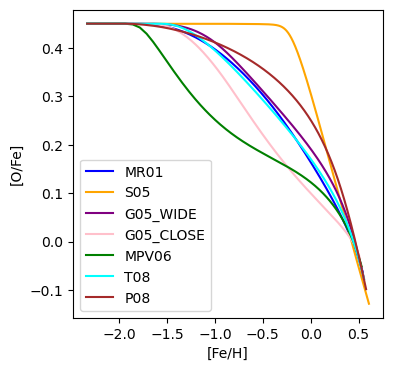

In [9]:
expifr = OneInfall(timescale=7, amplitude=1)

params = dict(
    elements=('fe', 'si', 'o'),
    mode='ifr',
    dt=dt,
    eta=0.4,
    Mg0=0,
    recycling=0.285,
    tau_star=2,
    enhancement=1,
    Zin=0,
)

fig, ax = plt.subplots(figsize=(4, 4))
for dtd in dtd_list:
    output_name = str(onezone_dir / 'oneinfall' / dtd['name'])
    sz = vice.singlezone(name=output_name, 
                         func=expifr,
                         RIa=dtd['RIa'],
                         delay=dtd['delay'],
                         **params)
    sz.run(simtime, overwrite=True)
    hist = vice.history(output_name)
    ax.plot(hist['[fe/h]'], hist['[o/fe]'], label=dtd['name'], color=dtd['color'])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()

## Two Infalls

In [10]:
class TwoInfall(OneInfall):
    def __init__(self, timescale1=1, amplitude1=1, timescale2=1, amplitude2=1, onset2=1):
        self.infall1 = OneInfall(timescale=timescale1, amplitude=amplitude1)
        self.infall2 = OneInfall(timescale=timescale2, amplitude=amplitude2)
        self.onset2 = onset2
    
    def __call__(self, time):
        if time < self.onset2:
            return self.infall1(time)
        else:
            return self.infall1(time) + self.infall2(time - self.onset2)

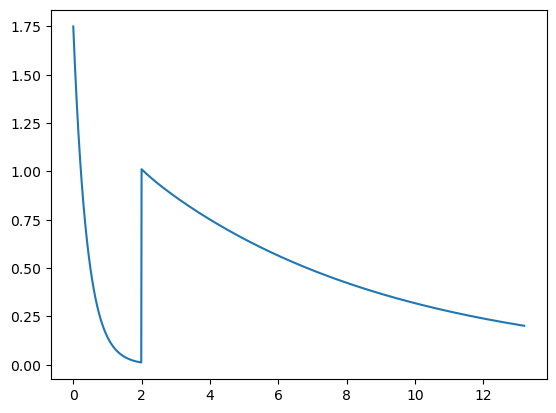

In [37]:
ifr1 = TwoInfall(timescale1=0.4, timescale2=7, onset2=2, 
                      amplitude1=1.75, amplitude2=1)
fig, ax = plt.subplots()
plt.plot(simtime, [ifr1(t) for t in simtime])
plt.show()

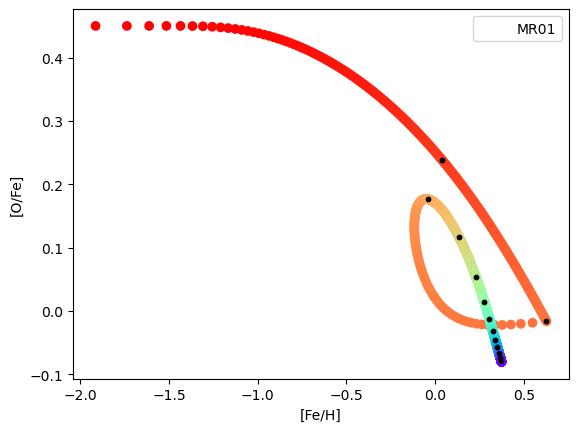

In [51]:
params = dict(
    elements=('fe', 'o'),
    mode='ifr',
    dt=dt,
    eta=0.8,
    Mg0=0,
    recycling=0.4,
    tau_star=0.75,
    enhancement=1,
    Zin=0,
)

dtd = MR01
output_name = str(onezone_dir / 'twoinfall' / 'model1')
sz = vice.singlezone(name=output_name, 
                     func=ifr1,
                     RIa=dtd['RIa'],
                     delay=dtd['delay'],
                     **params)
sz.run(simtime, overwrite=True)
hist = vice.history(output_name)

fig, ax = plt.subplots()
ax.scatter(hist['[fe/h]'], hist['[o/fe]'], label=dtd['name'], c=hist['lookback'], cmap='rainbow')
ax.scatter(hist['[fe/h]'][::100], hist['[o/fe]'][::100], c='k', s=10)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()

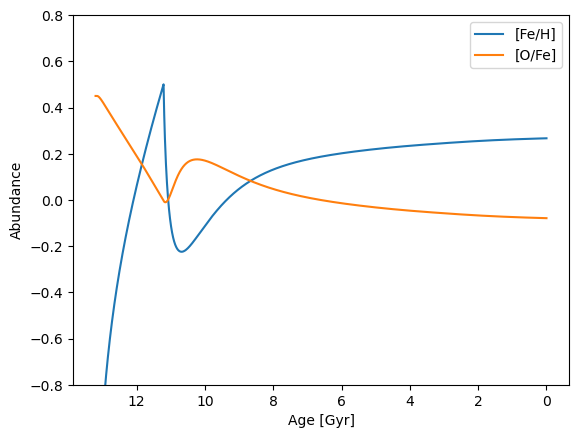

In [35]:
dtd = MR01
output_name = str(onezone_dir / 'twoinfall' / dtd['name'])
hist = vice.history(output_name)

fig, ax = plt.subplots()
ax.plot(hist['lookback'], hist['[fe/h]'], label='[Fe/H]')
ax.plot(hist['lookback'], hist['[o/fe]'], label='[O/Fe]')
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('Abundance')
ax.invert_xaxis()
ax.set_ylim((-0.8, 0.8))
ax.legend()
plt.show()

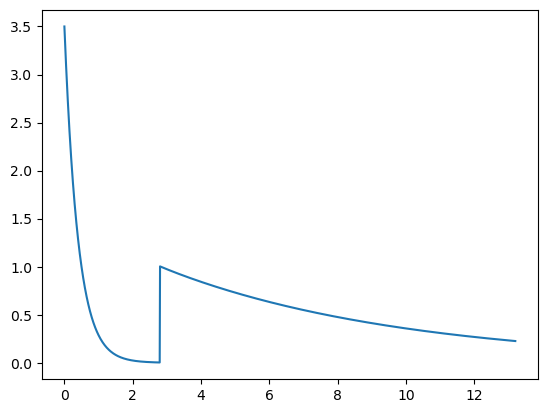

In [149]:
ifr2 = TwoInfall(timescale1=0.4, timescale2=7, onset2=2.8, 
                      amplitude1=3.5, amplitude2=1.0)
fig, ax = plt.subplots()
plt.plot(simtime, [ifr2(t) for t in simtime])
plt.show()

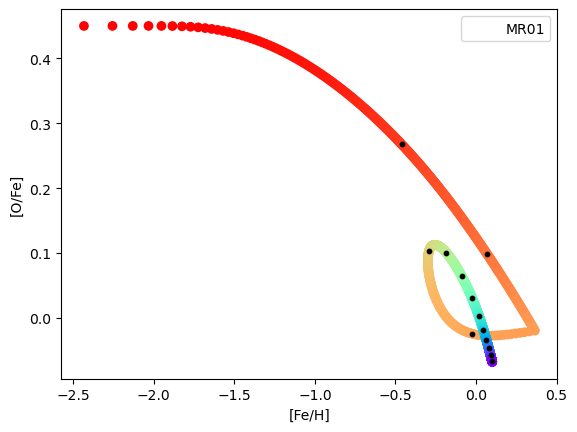

In [151]:
params = dict(
    elements=('fe', 'o'),
    mode='ifr',
    dt=dt,
    eta=vice.milkyway.default_mass_loading(8),
    Mg0=0,
    recycling=0.4,
    tau_star=2.5,
    enhancement=1,
    Zin=0,
)

dtd = MR01
output_name = str(onezone_dir / 'twoinfall' / 'model2')
sz = vice.singlezone(name=output_name, 
                     func=ifr2,
                     RIa=dtd['RIa'],
                     delay=dtd['delay'],
                     **params)
sz.run(simtime, overwrite=True)
hist = vice.history(output_name)

fig, ax = plt.subplots()
ax.scatter(hist['[fe/h]'], hist['[o/fe]'], label=dtd['name'], c=hist['lookback'], cmap='rainbow')
ax.scatter(hist['[fe/h]'][::100], hist['[o/fe]'][::100], c='k', s=10)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()

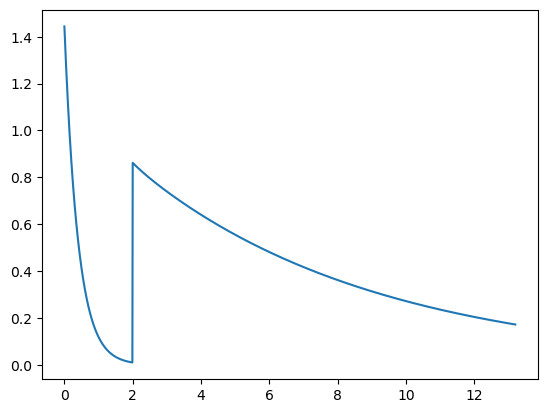

In [14]:
from src.simulations.models.twoinfall import twoinfall

ifr_solar = twoinfall(8)

fig, ax = plt.subplots()
ax.plot(simtime, [ifr_solar(t) for t in simtime])
plt.show()

In [16]:
thin_to_thick_ratio = sum([ifr_solar(t) for t in simtime if t > 2]) / sum([ifr_solar(t) for t in simtime if t <= 2])
print(thin_to_thick_ratio)

8.07671036766817


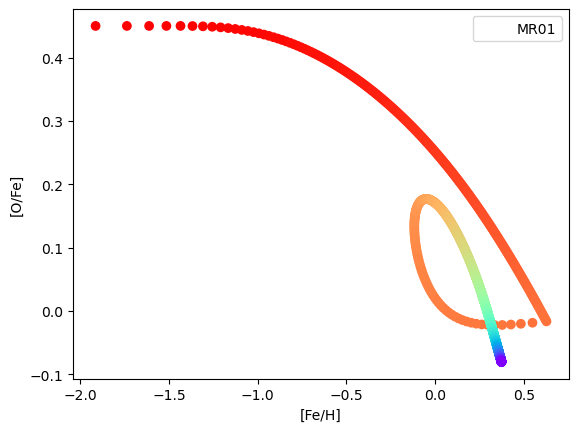

In [15]:
params = dict(
    elements=('fe', 'o'),
    mode='ifr',
    dt=dt,
    eta=0.8,
    Mg0=0,
    recycling=0.4,
    tau_star=0.75,
    enhancement=1,
    Zin=0,
)

dtd = MR01
output_name = str(onezone_dir / 'twoinfall' / 'diskparam')
sz = vice.singlezone(name=output_name, 
                     func=ifr2,
                     RIa=dtd['RIa'],
                     delay=dtd['delay'],
                     **params)
sz.run(simtime, overwrite=True)
hist = vice.history(output_name)

fig, ax = plt.subplots()
ax.scatter(hist['[fe/h]'], hist['[o/fe]'], label=dtd['name'], c=hist['lookback'], cmap='rainbow')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()